In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

desired_directory = '/content/drive/MyDrive/ECE661_Final'

os.chdir(desired_directory)

current_directory = os.getcwd()
print(f'Current working directory is now: {current_directory}')

Current working directory is now: /content/drive/MyDrive/ECE661_Final


In [4]:
!pip install torch torchvision

In [5]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

# Data Loader

In [6]:
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                 std=[0.2023, 0.1994, 0.201])

In [7]:
train_dataset = CIFAR10(root='./data',
                                 train=True,
                                 transform=transforms.Compose([transforms.ToTensor(),normalize]),
                                 download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=4,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)

test_dataset = CIFAR10(root='./data',
                                 train=False,
                                 transform=transforms.Compose([transforms.ToTensor(),normalize]),
                                 download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)

NUM_CLASSES = 10

Files already downloaded and verified
Files already downloaded and verified


# Load Pre-trained Model

In [8]:
resnet20 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
resnet56 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True)
vgg16 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg16_bn", pretrained=True)
mobilenet = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_mobilenetv2_x1_4", pretrained=True)
shufflenet = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_shufflenetv2_x2_0", pretrained=True)
repvgg = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_repvgg_a2", pretrained=True)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [9]:
def validate(model,loader):
    global device
    model.eval()
    correct = 0.
    total = 0.
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            pred = model(images)

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    val_acc = (correct / total)*100
    model.train()
    return val_acc

In [10]:
device = torch.device("cuda")

In [ ]:
print(validate(resnet20.to(device), test_loader))

92.60000000000001


In [12]:
MODELS = {
    'resnet20': resnet20,
    'resnet56': resnet56,
    'vgg': vgg16,
    'mobilenet': mobilenet,
    'shufflenet': shufflenet,
    'repvgg': repvgg
}

# Util Functions

In [13]:
def gradient_wrt_data(model,device,data,lbl):
    dat = data.clone().detach()
    dat.requires_grad = True
    out = model(dat)
    loss = F.cross_entropy(out,lbl)
    model.zero_grad()
    loss.backward()
    data_grad = dat.grad.data
    return data_grad.data.detach()

In [14]:
def get_first_non_zero(input):
  for i in range(len(input)):
    for j in range(len(input[i])):
      for k in range(len(input[i][j])):
        if input[i][j][k] != 0:
          return j, k
  return 0, 0

In [15]:
def collect_patch(full_patch, shape, device):
  np_full = full_patch.cpu().detach().numpy()
  patch = np.zeros(shape)

  y, x = get_first_non_zero(np_full)

  for i in range(shape[0]):
    for j in range(shape[1]):
      for k in range(shape[2]):
        full = np_full[i][y + j][x + k]
        patch[i][j][k] = full

  return torch.from_numpy(patch).to(device)

In [16]:
def attack_batch(model, target, data, patch, device, attack_targeted, labels, learning_rate=0.1, max_iters=1):
  model.eval()

  data_np = data.cpu().detach().numpy()
  batch_size = data_np.shape[0]

  full_patchs, masks = get_full_patch(data, patch, device)
  cutout_image = torch.mul(1-masks, data)
  adv_imgs = torch.add(cutout_image, full_patchs)

  conf = 0
  target_label = torch.from_numpy(np.ones(data_np.shape[0], dtype=np.int64) * target).to(device) if attack_targeted else target

  iterations = 0
  while iterations < max_iters:
    grad = learning_rate * gradient_wrt_data(model, device, adv_imgs.float(), target_label)

    new_patch = torch.sub(full_patchs, grad) if attack_targeted else torch.add(full_patchs, grad)
    new_patch[:][0] = torch.clamp(new_patch[:][0], min=-2.429, max=2.514).detach()
    new_patch[:][1] = torch.clamp(new_patch[:][1], min=-2.418, max=2.597).detach()
    new_patch[:][2] = torch.clamp(new_patch[:][2], min=-2.221, max=2.754).detach()
    full_patchs = torch.mul(new_patch, masks)

    adv_imgs = torch.add(cutout_image, full_patchs)
    iterations += 1

  avg_patch = torch.mean(full_patchs, 0)
  output = model(adv_imgs.float())
  _, preds = output.max(1)
  correct = preds.eq(labels).sum().item()

  patch = collect_patch(avg_patch, patch.shape, device)
  return patch, correct / batch_size


In [17]:
def get_full_patch(data, patch, device, fixed_location=None):
  patch_np = patch.cpu().detach().numpy()
  data_np = data.cpu().detach().numpy()

  if fixed_location is None:
    top = np.random.randint(0, data_np.shape[2] - patch_np.shape[1])
    right = np.random.randint(0, data_np.shape[3] - patch_np.shape[2])
  else:
    top = fixed_location[0]
    right = fixed_location[1]

  mask = np.zeros(data.shape)
  full_patch = np.zeros(data.shape)
  for n in range(data_np.shape[0]):
    for i in range(patch_np.shape[0]):
      for j in range(patch_np.shape[1]):
        for k in range(patch_np.shape[2]):
          full_patch[n][i][top + j][right + k] = patch_np[i][j][k]
          mask[n][i][top + j][right + k] = 1
  return torch.from_numpy(full_patch).to(device), torch.from_numpy(mask).to(device)

In [18]:
def train_patch(model, data_loader, target, device, patch_size=(3,3), max_iters=30, conf_level=1):
  model.eval()

  patch = torch.from_numpy(np.zeros((3, patch_size[0], patch_size[1]))).to(device)

  for i in range(3):
    batch_num = 0
    ep_acc = 0
    lr = 0.1
    for batch_idx, (data, labels) in enumerate(data_loader):
      data = data.to(device)
      labels = labels.to(device)

      if target == labels.cpu().data[0].numpy() and target != None: continue

      batch_num += 1

      target = labels.cpu().data[0].numpy() if target == None else target
      attack_targeted = False if target == None else True

      patch, acc = attack_batch(model, target, data, patch, device, attack_targeted, labels, learning_rate=lr)
      ep_acc += acc
      batch_num += 1

      if batch_num >= 10000: break

    print('Epoch ', i, ', Accuracy: ', ep_acc / batch_num)
  return patch

In [19]:
def test_patch(model, data_loader, target, patch, device):
  model.eval()
  patch_success = 0
  model_success = 0
  total = 0

  for batch_idx, (data, labels) in enumerate(data_loader):
    if target == labels.data[0] and target != None: continue

    total += 1
    data = data.to(device)
    labels = labels.to(device)

    full_patch, mask = get_full_patch(data, patch, device)
    cutout_image = torch.mul(1-mask, data)
    adv_img = torch.add(cutout_image, full_patch)

    adv_label = model(adv_img.float()).data.max(1)[1][0]
    orig_label = labels.data[0]

    if target != None and adv_label == target: patch_success += 1
    elif adv_label == orig_label: model_success += 1

  test_acc = model_success / total
  asr = patch_success / total
  print('Model test accuracy: ' + f'{model_success / total:.2f}')
  print('Attack Success Rate: ' + f'{patch_success / total:.2f}')

  return test_acc, asr

In [78]:
def imshow(img):
    timg = torch.clone(img)
    timg[0] = img[0] * 0.2023 + 0.4914
    timg[1] = img[1] * 0.1994 + 0.4822
    timg[2] = img[2] * 0.201 + 0.4465
    timg = torch.clamp(timg, 0, 1)  # Clamping the pixel values
    npimg = timg.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified


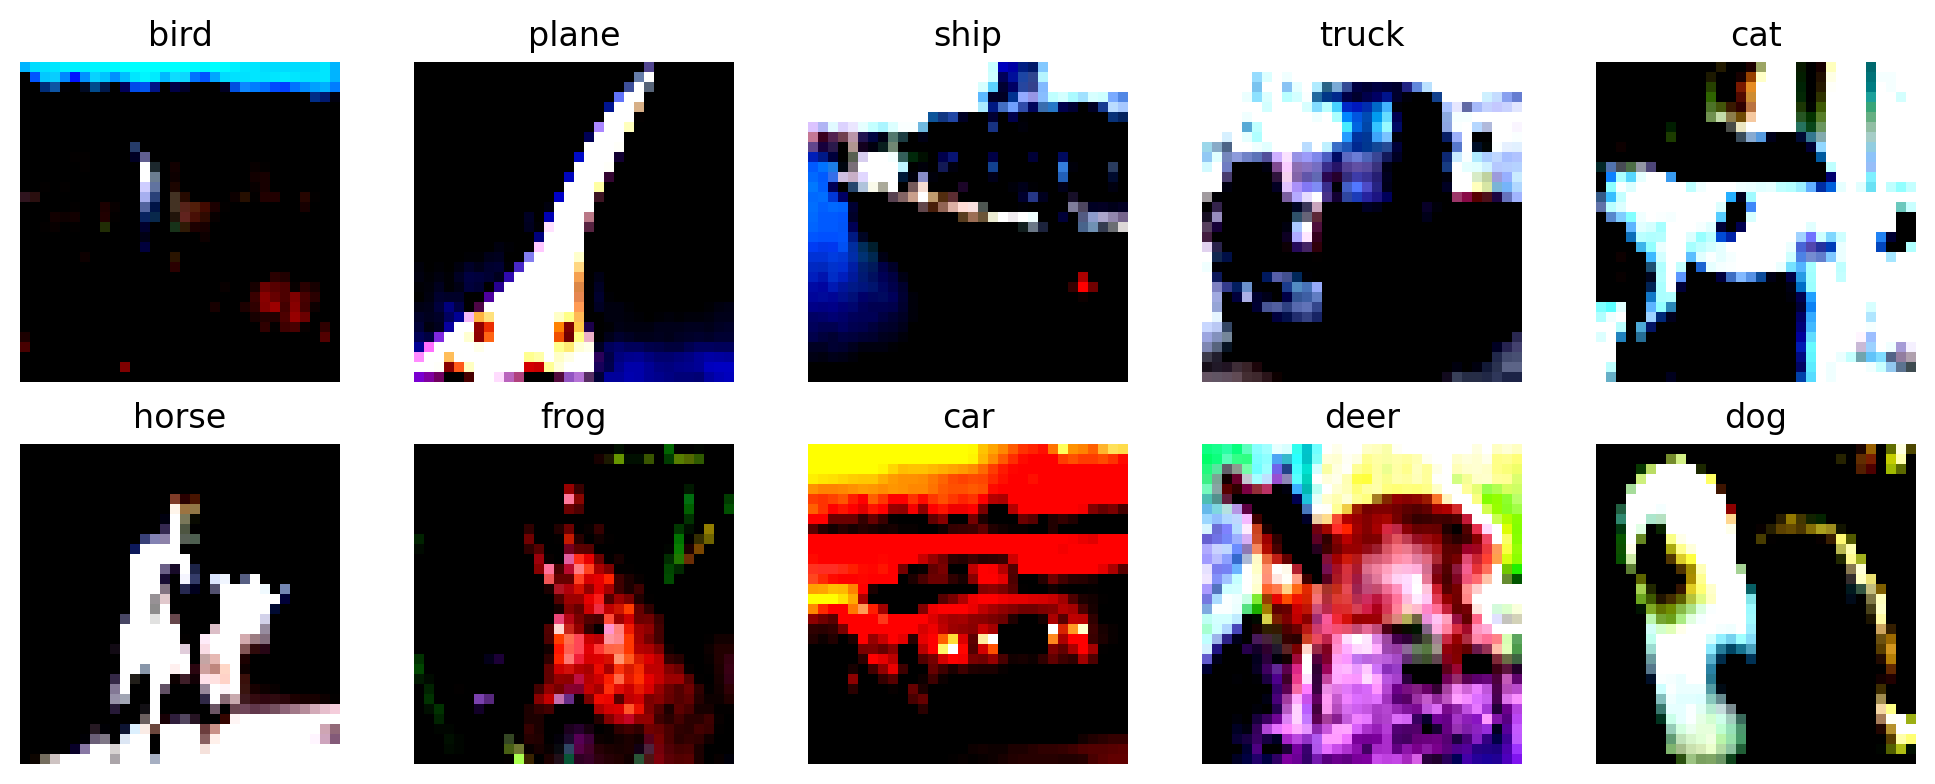

In [81]:
display_dataset = CIFAR10(root='./data', train=True, transform=transforms.Compose([transforms.ToTensor(), normalize]), download=True)
display_loader = DataLoader(dataset=display_dataset, batch_size=1, shuffle=True, pin_memory=True, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Dictionary to hold one image per class
class_images = {}

# Iterate over the training dataset
for images, labels in display_loader:
    label = labels.item()
    if label not in class_images:
        class_images[label] = images[0]  # Store the first image of each class
    if len(class_images) == 10:  # Stop when we have one of each class
        break

# Plot one image per class
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()

for class_idx, (class_label, img_tensor) in enumerate(class_images.items()):
    axes[class_idx].imshow(img_tensor.permute(1, 2, 0))  # Convert CxHxW to HxWxC
    axes[class_idx].set_title(f'{classes[class_label]}')
    axes[class_idx].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

# Baseline Experiments

In [ ]:
my_patch_resnet20_3x3_untargeted = train_patch(MODELS['Resnet20'].to(device), train_loader, None, device, (3,3))

Epoch  0 , Accuracy:  0.4735
Epoch  1 , Accuracy:  0.4714
Epoch  2 , Accuracy:  0.470125
Epoch  3 , Accuracy:  0.46745
Epoch  4 , Accuracy:  0.467775
Epoch  5 , Accuracy:  0.4643
Epoch  6 , Accuracy:  0.465525
Epoch  7 , Accuracy:  0.4646
Epoch  8 , Accuracy:  0.463975
Epoch  9 , Accuracy:  0.4654


In [ ]:
my_patch_resnet20_16x16_untargeted = train_patch(MODELS['Resnet20'].to(device), train_loader, None, device, (16,16))

Epoch  0 , Accuracy:  0.03895
Epoch  1 , Accuracy:  0.037525
Epoch  2 , Accuracy:  0.0375
Epoch  3 , Accuracy:  0.0375
Epoch  4 , Accuracy:  0.037475
Epoch  5 , Accuracy:  0.0375
Epoch  6 , Accuracy:  0.037525
Epoch  7 , Accuracy:  0.037475
Epoch  8 , Accuracy:  0.037475
Epoch  9 , Accuracy:  0.037475


Epoch  0 , Accuracy:  0.48025
Epoch  1 , Accuracy:  0.46575
Epoch  2 , Accuracy:  0.464275


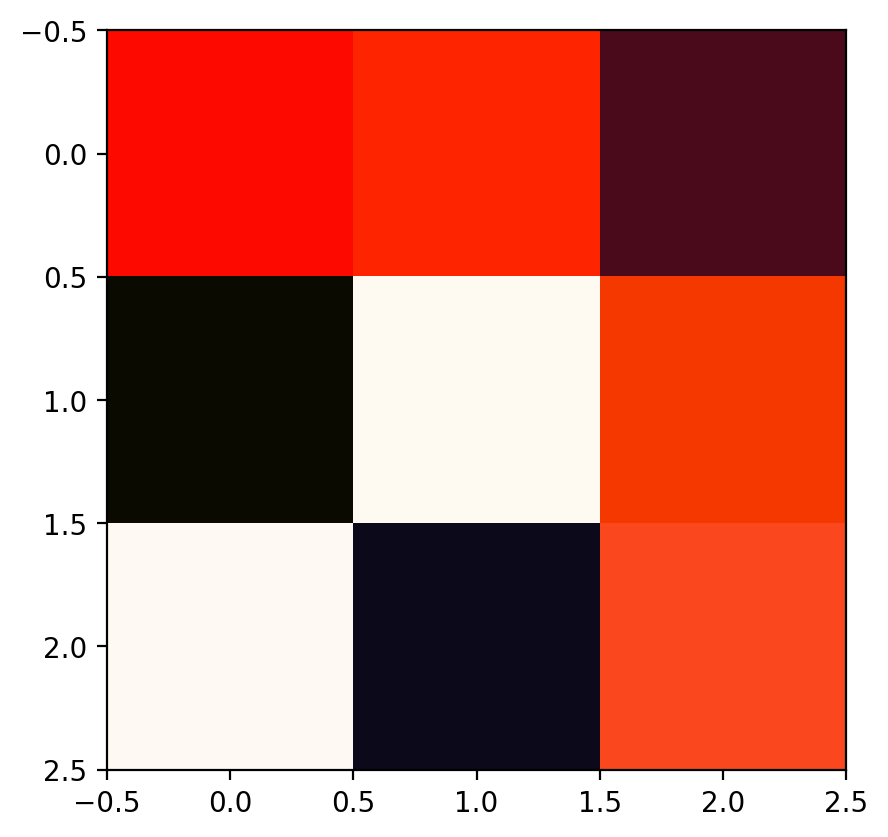

Model test accuracy: 0.86
Attack Success Rate: 0.00
Epoch  0 , Accuracy:  0.4659
Epoch  1 , Accuracy:  0.457825
Epoch  2 , Accuracy:  0.45765


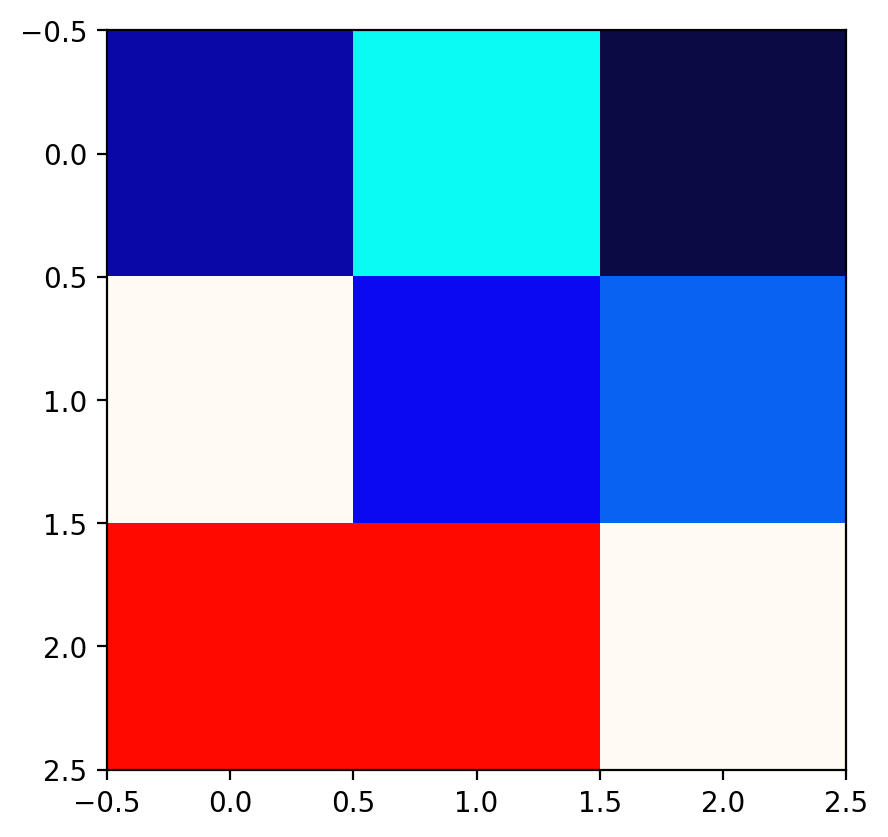

Model test accuracy: 0.83
Attack Success Rate: 0.05
Epoch  0 , Accuracy:  0.47985
Epoch  1 , Accuracy:  0.4758
Epoch  2 , Accuracy:  0.4764


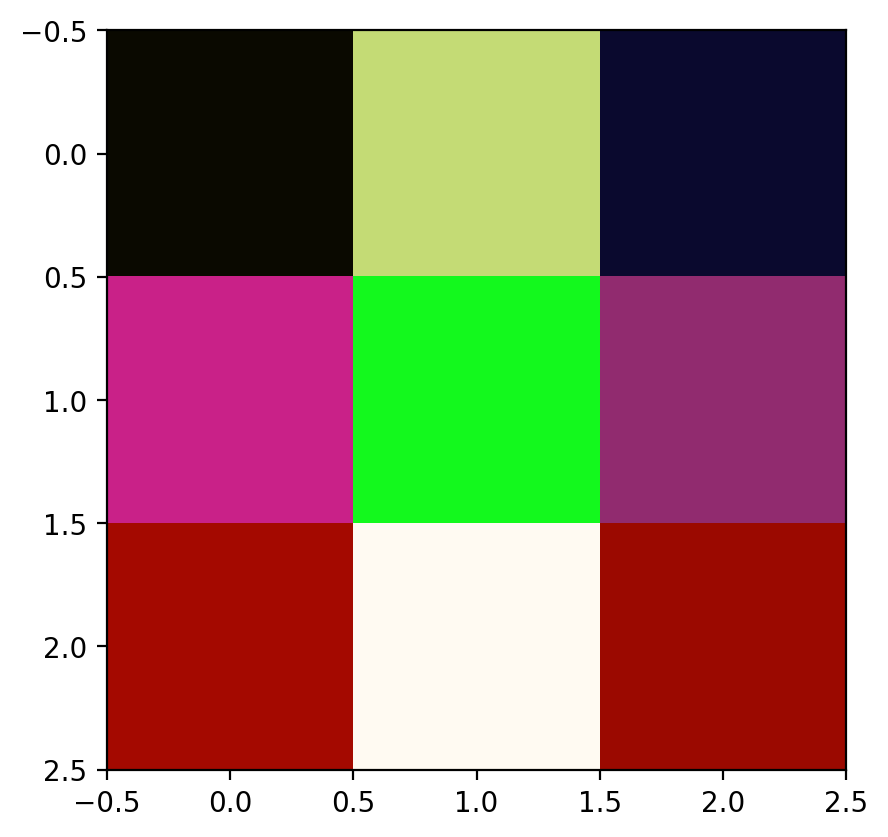

Model test accuracy: 0.87
Attack Success Rate: 0.05
Epoch  0 , Accuracy:  0.480025
Epoch  1 , Accuracy:  0.46965
Epoch  2 , Accuracy:  0.46445


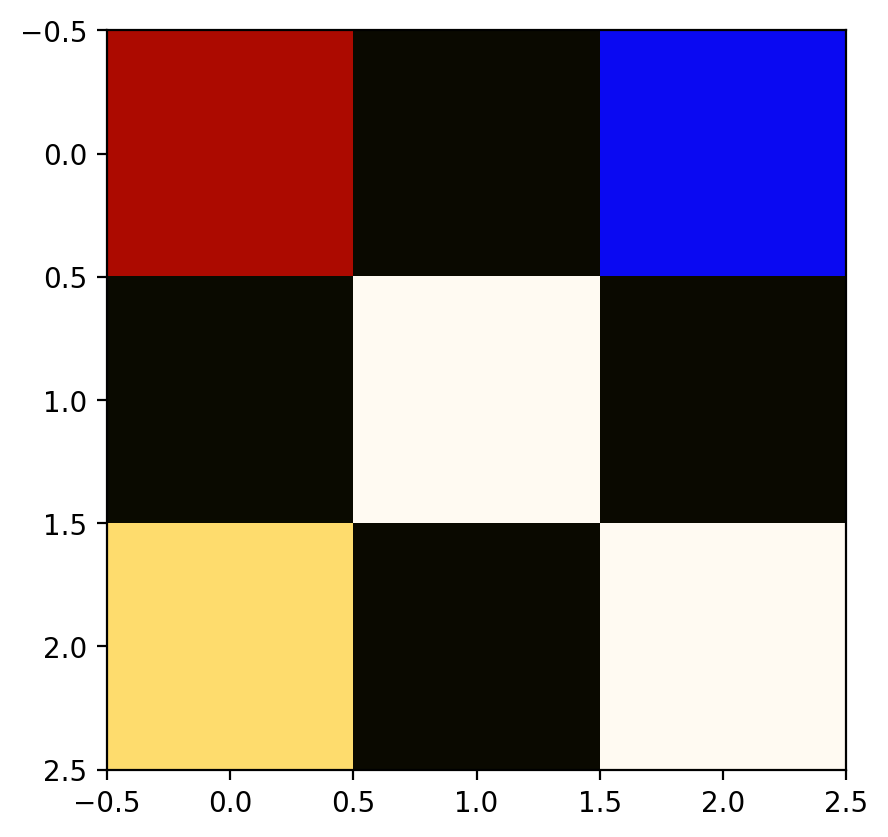

Model test accuracy: 0.86
Attack Success Rate: 0.00
Epoch  0 , Accuracy:  0.474525
Epoch  1 , Accuracy:  0.467975
Epoch  2 , Accuracy:  0.4686


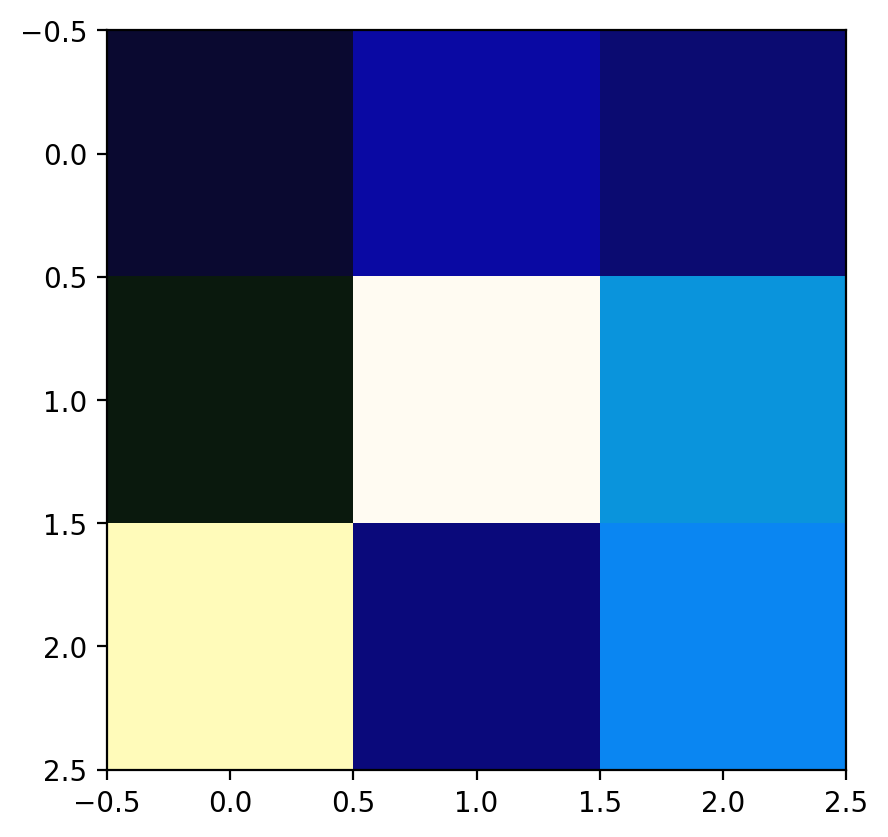

Model test accuracy: 0.86
Attack Success Rate: 0.01
Epoch  0 , Accuracy:  0.428775
Epoch  1 , Accuracy:  0.396175
Epoch  2 , Accuracy:  0.383475


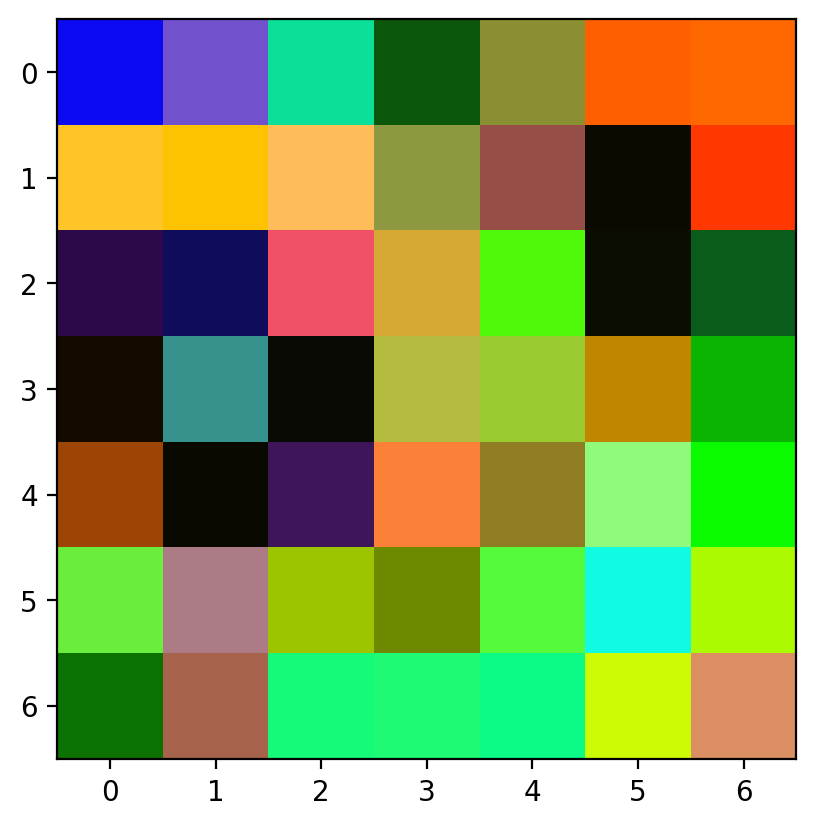

Model test accuracy: 0.72
Attack Success Rate: 0.00
Epoch  0 , Accuracy:  0.419325
Epoch  1 , Accuracy:  0.37095
Epoch  2 , Accuracy:  0.356125


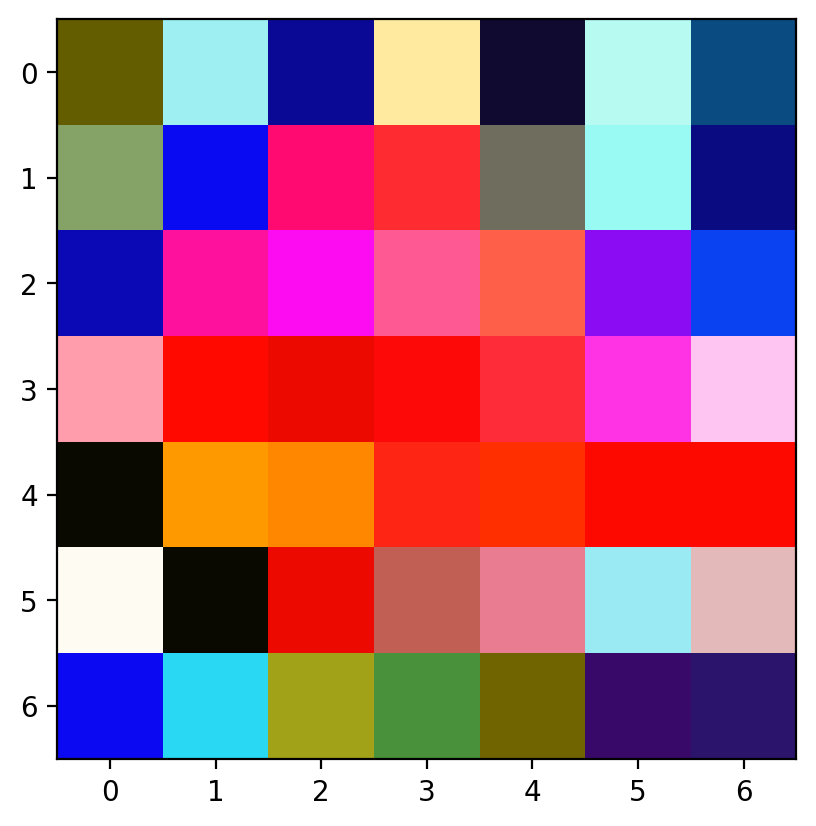

Model test accuracy: 0.63
Attack Success Rate: 0.23
Epoch  0 , Accuracy:  0.3549
Epoch  1 , Accuracy:  0.257075
Epoch  2 , Accuracy:  0.25065


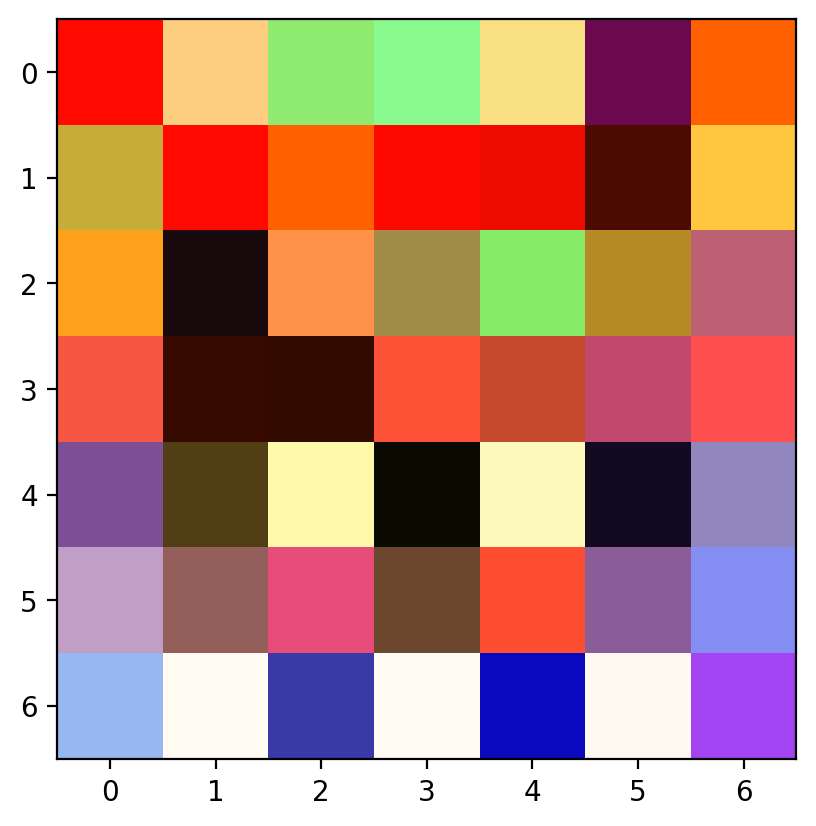

Model test accuracy: 0.42
Attack Success Rate: 0.56
Epoch  0 , Accuracy:  0.440075
Epoch  1 , Accuracy:  0.40355
Epoch  2 , Accuracy:  0.399325


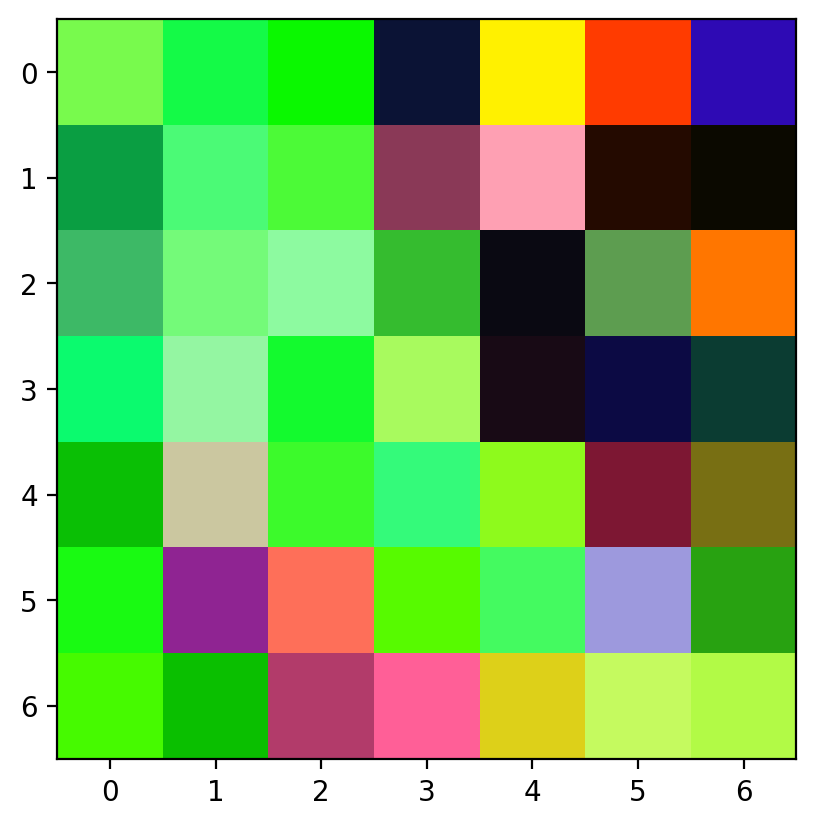

Model test accuracy: 0.71
Attack Success Rate: 0.18
Epoch  0 , Accuracy:  0.4181
Epoch  1 , Accuracy:  0.3859
Epoch  2 , Accuracy:  0.380025


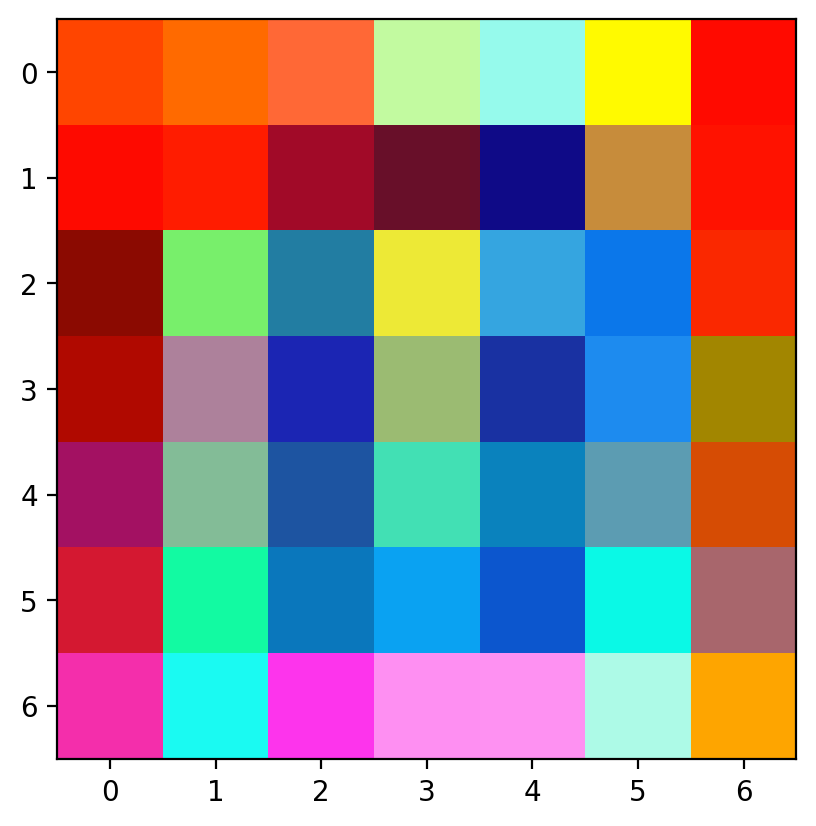

Model test accuracy: 0.68
Attack Success Rate: 0.23
Epoch  0 , Accuracy:  0.20545
Epoch  1 , Accuracy:  0.132875
Epoch  2 , Accuracy:  0.116725


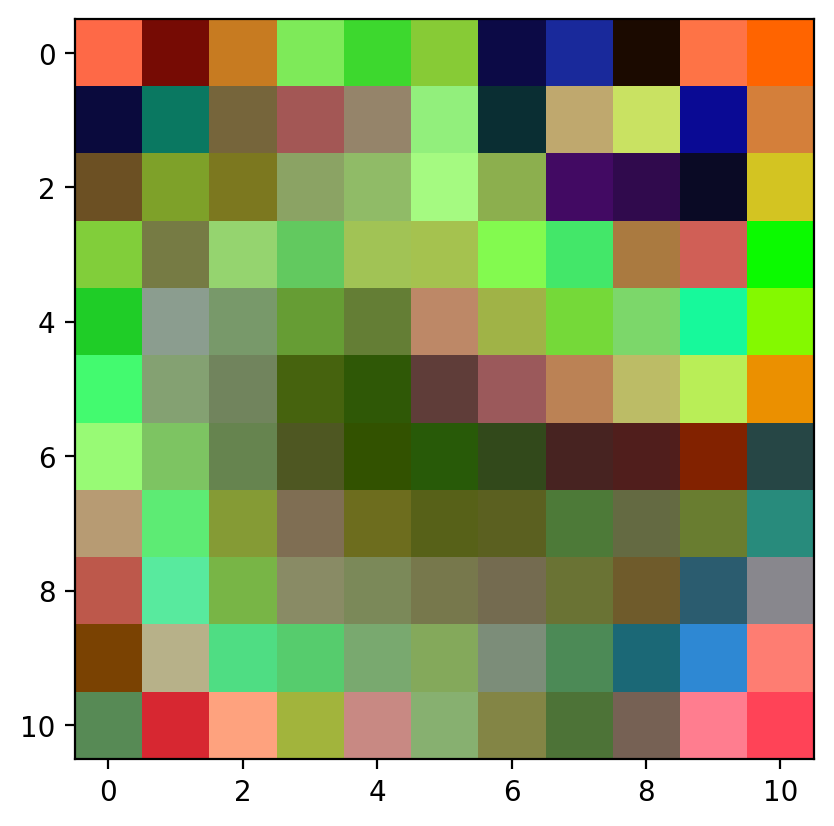

Model test accuracy: 0.24
Attack Success Rate: 0.00
Epoch  0 , Accuracy:  0.20535
Epoch  1 , Accuracy:  0.141225
Epoch  2 , Accuracy:  0.125875


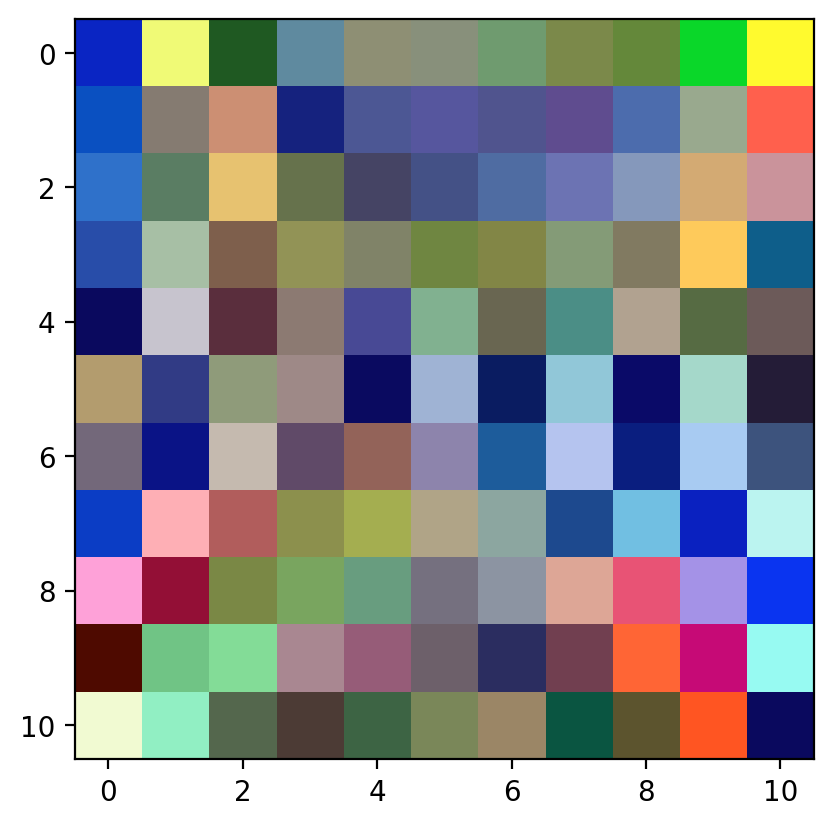

Model test accuracy: 0.18
Attack Success Rate: 0.81
Epoch  0 , Accuracy:  0.112975
Epoch  1 , Accuracy:  0.0736
Epoch  2 , Accuracy:  0.0687


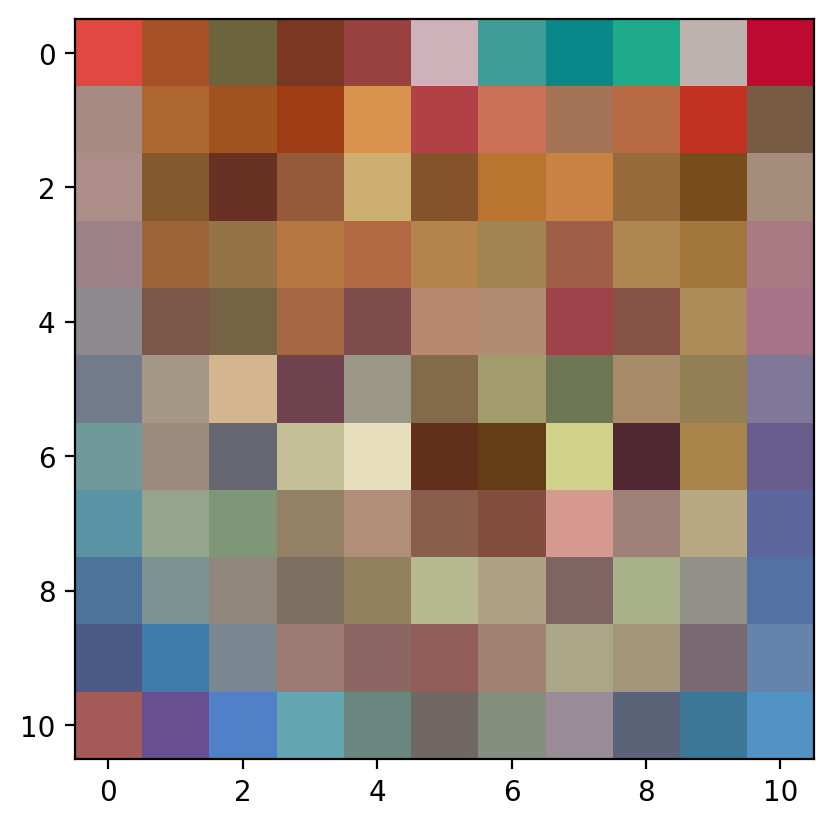

Model test accuracy: 0.06
Attack Success Rate: 0.94
Epoch  0 , Accuracy:  0.196875
Epoch  1 , Accuracy:  0.114325
Epoch  2 , Accuracy:  0.10165


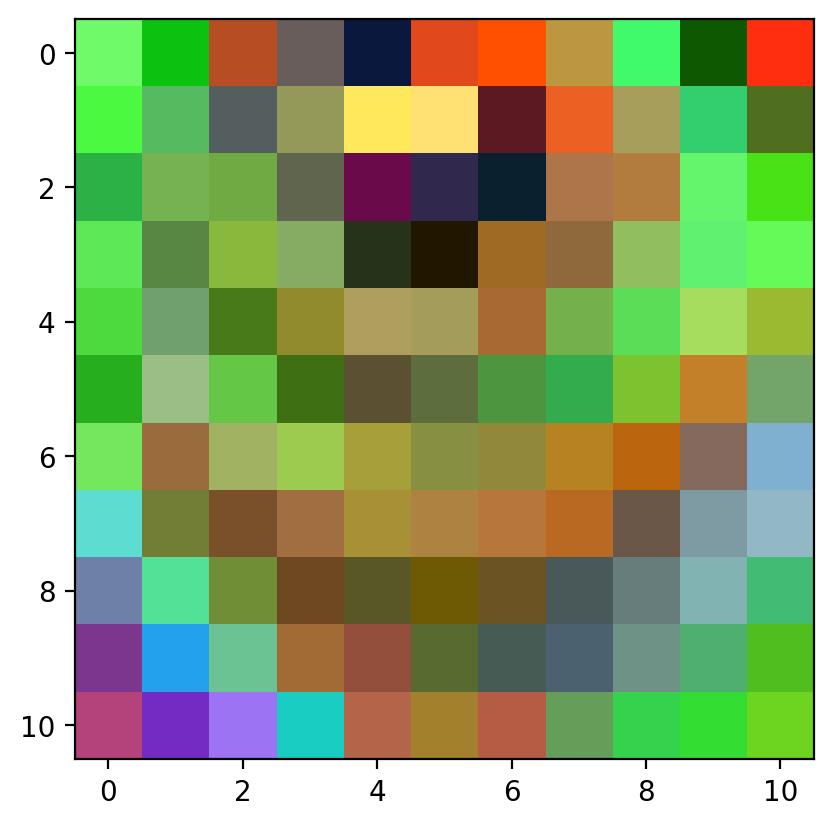

Model test accuracy: 0.13
Attack Success Rate: 0.87
Epoch  0 , Accuracy:  0.2041
Epoch  1 , Accuracy:  0.1448
Epoch  2 , Accuracy:  0.129025


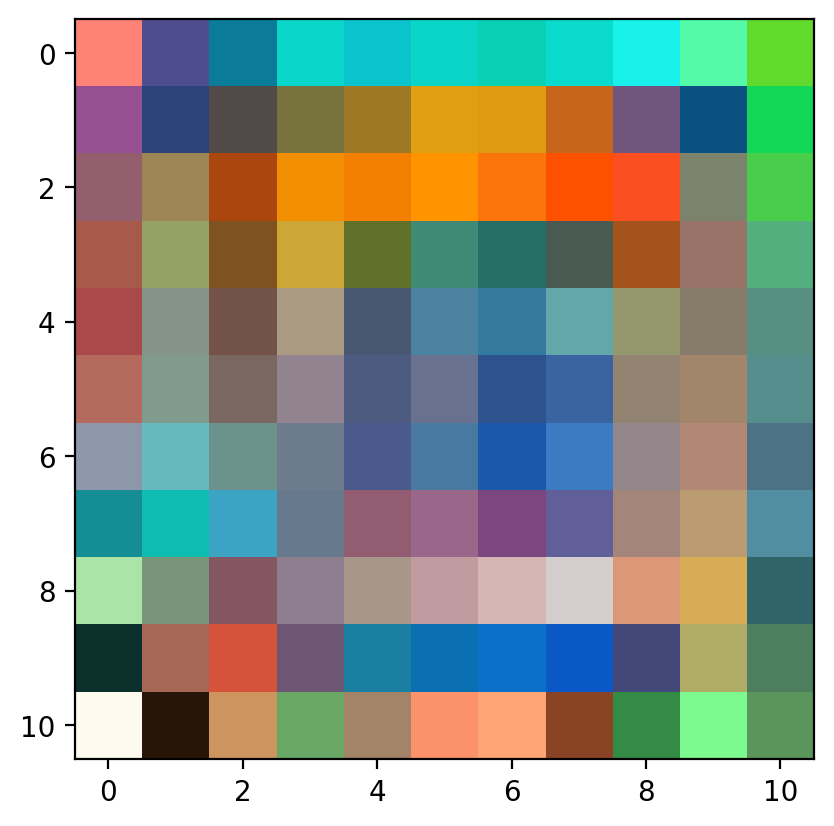

Model test accuracy: 0.17
Attack Success Rate: 0.83
Epoch  0 , Accuracy:  0.07995
Epoch  1 , Accuracy:  0.04725
Epoch  2 , Accuracy:  0.043575


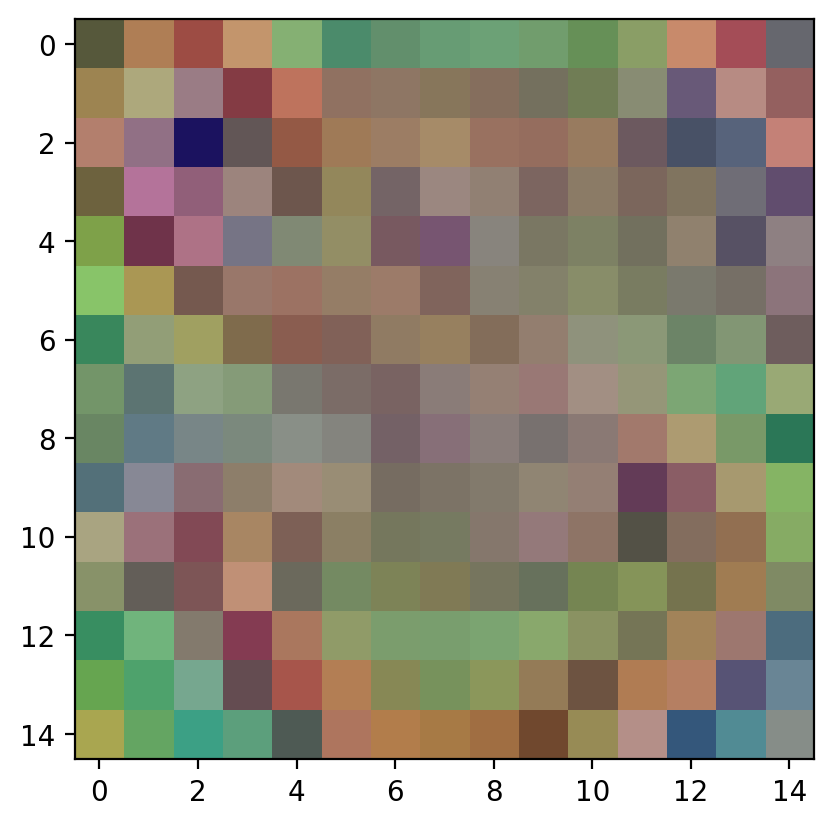

Model test accuracy: 0.11
Attack Success Rate: 0.00
Epoch  0 , Accuracy:  0.06055
Epoch  1 , Accuracy:  0.0441
Epoch  2 , Accuracy:  0.042275


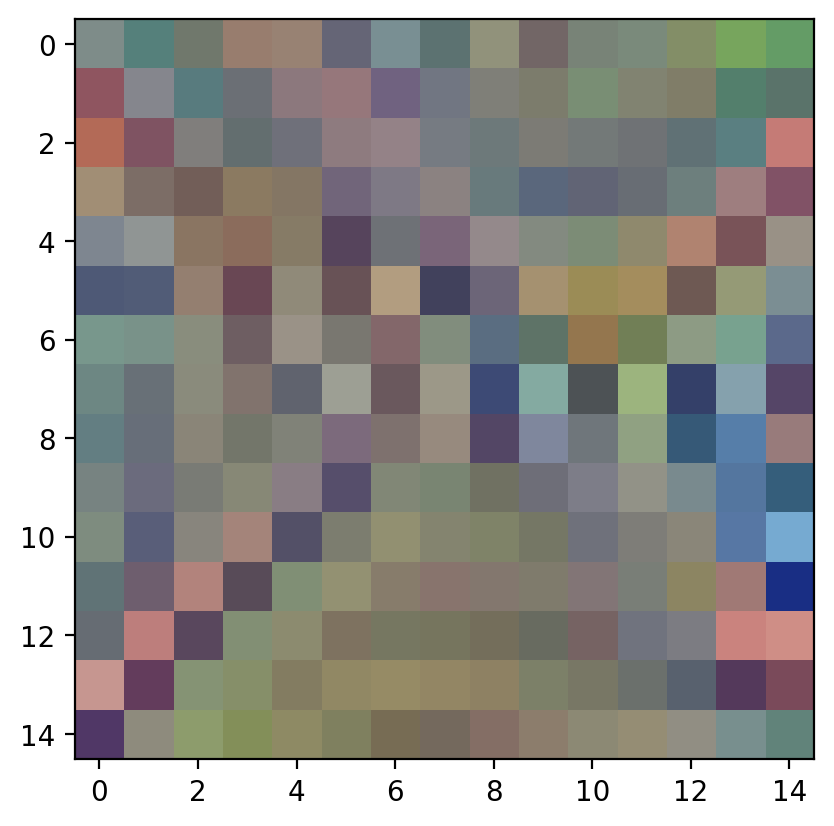

Model test accuracy: 0.01
Attack Success Rate: 0.99
Epoch  0 , Accuracy:  0.051775
Epoch  1 , Accuracy:  0.04245
Epoch  2 , Accuracy:  0.041225


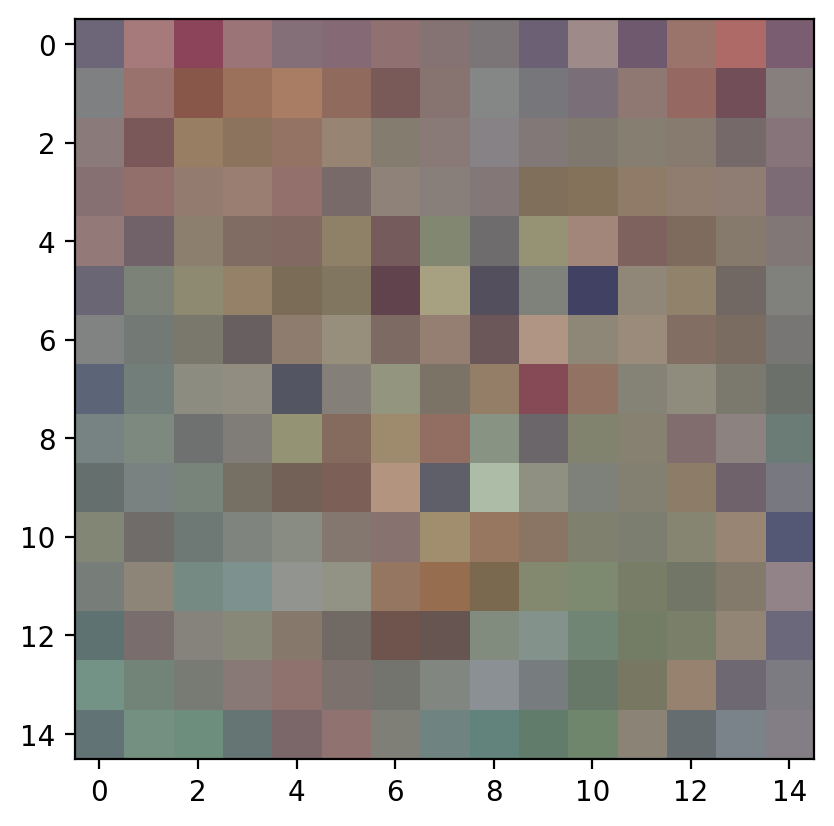

Model test accuracy: 0.01
Attack Success Rate: 0.99
Epoch  0 , Accuracy:  0.087675
Epoch  1 , Accuracy:  0.04835
Epoch  2 , Accuracy:  0.043675


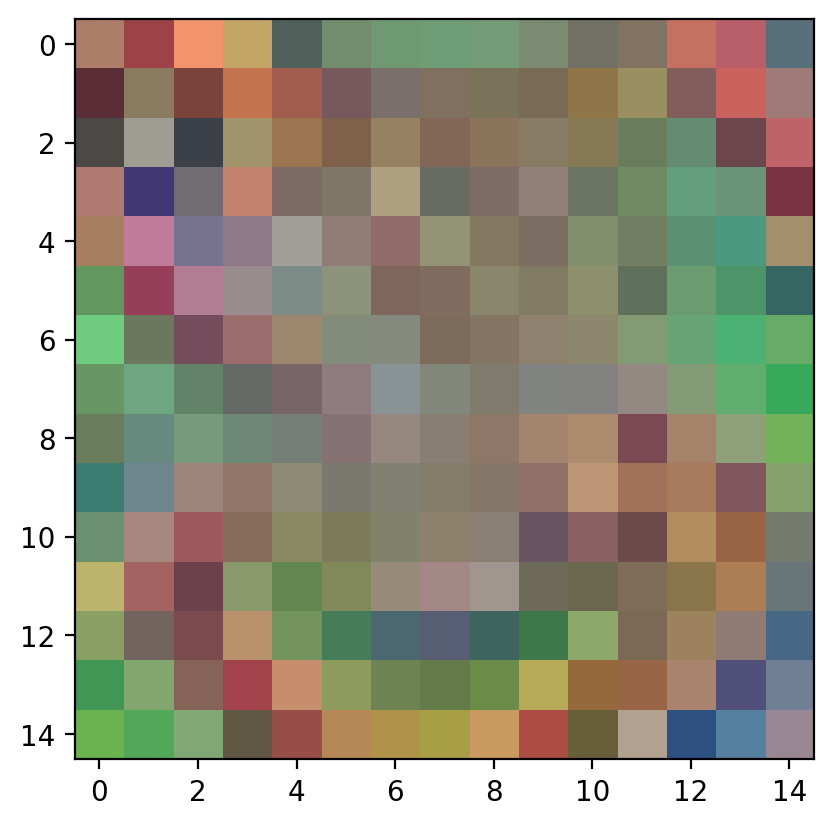

Model test accuracy: 0.02
Attack Success Rate: 0.98
Epoch  0 , Accuracy:  0.061875
Epoch  1 , Accuracy:  0.047975
Epoch  2 , Accuracy:  0.045225


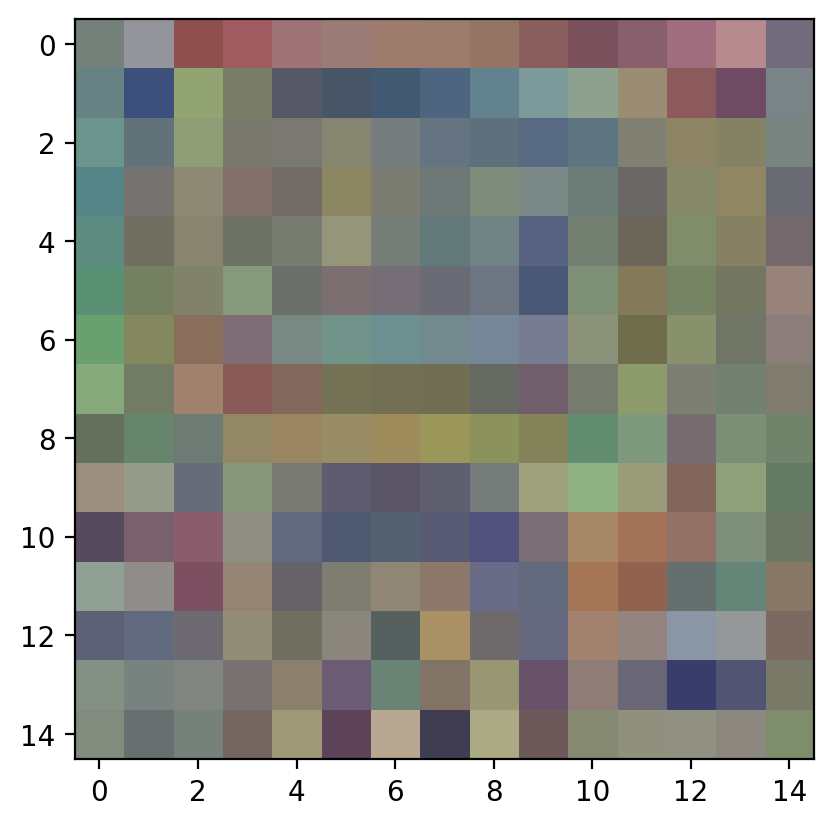

Model test accuracy: 0.02
Attack Success Rate: 0.98


In [ ]:
# Function for training and testing patches
def train_and_test_patches(patch_sizes, targets, model):
    results = {}
    for size in patch_sizes:
        results[size] = {}
        for target in targets:
            # Train patch
            patch = train_patch(model, train_loader, target, device, (size, size))
            imshow(patch.cpu())  # Display the patch
            # Test patch
            test_acc, asr = test_patch(model, test_loader, target, patch, device)
            results[size][target] = (test_acc, asr)
    return results

# Patch sizes and targets
patch_sizes = [3, 7, 11, 15]
targets = [None, 0, 3, 6, 9]  # None for untargeted, class numbers for targeted

# Train and test patches
results = train_and_test_patches(patch_sizes, targets, MODELS['Resnet20'])

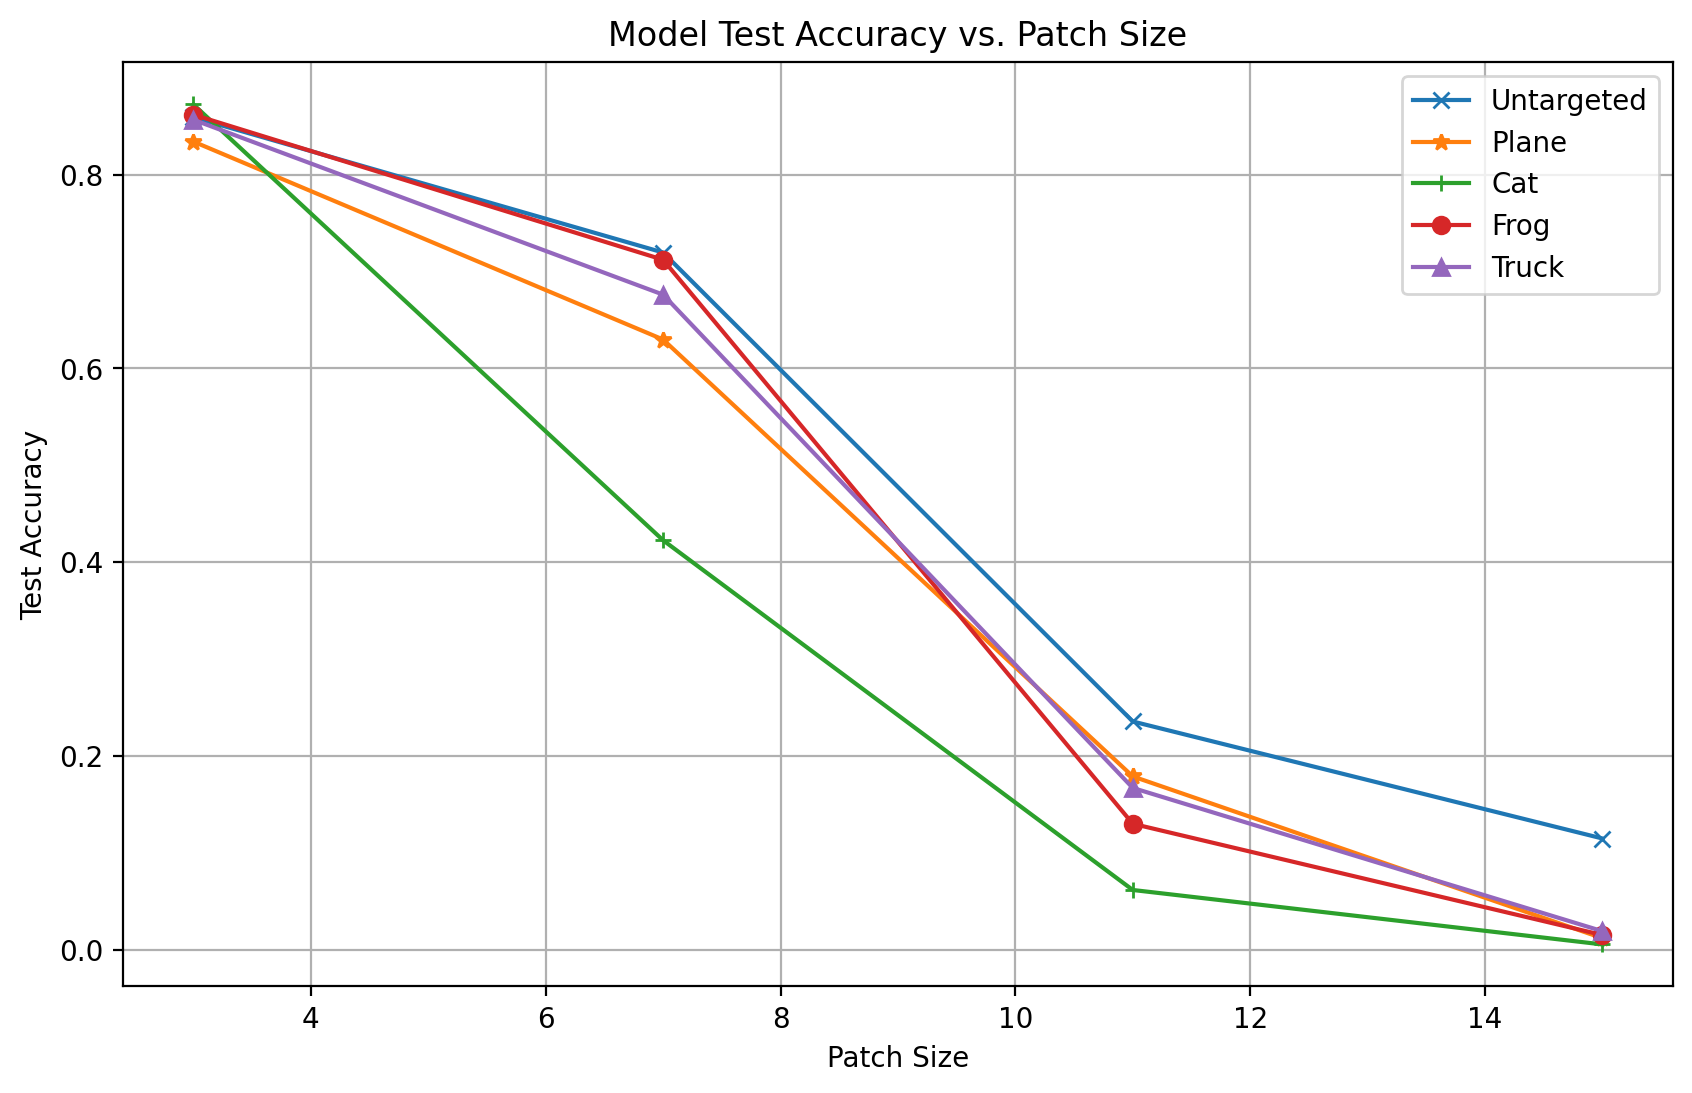

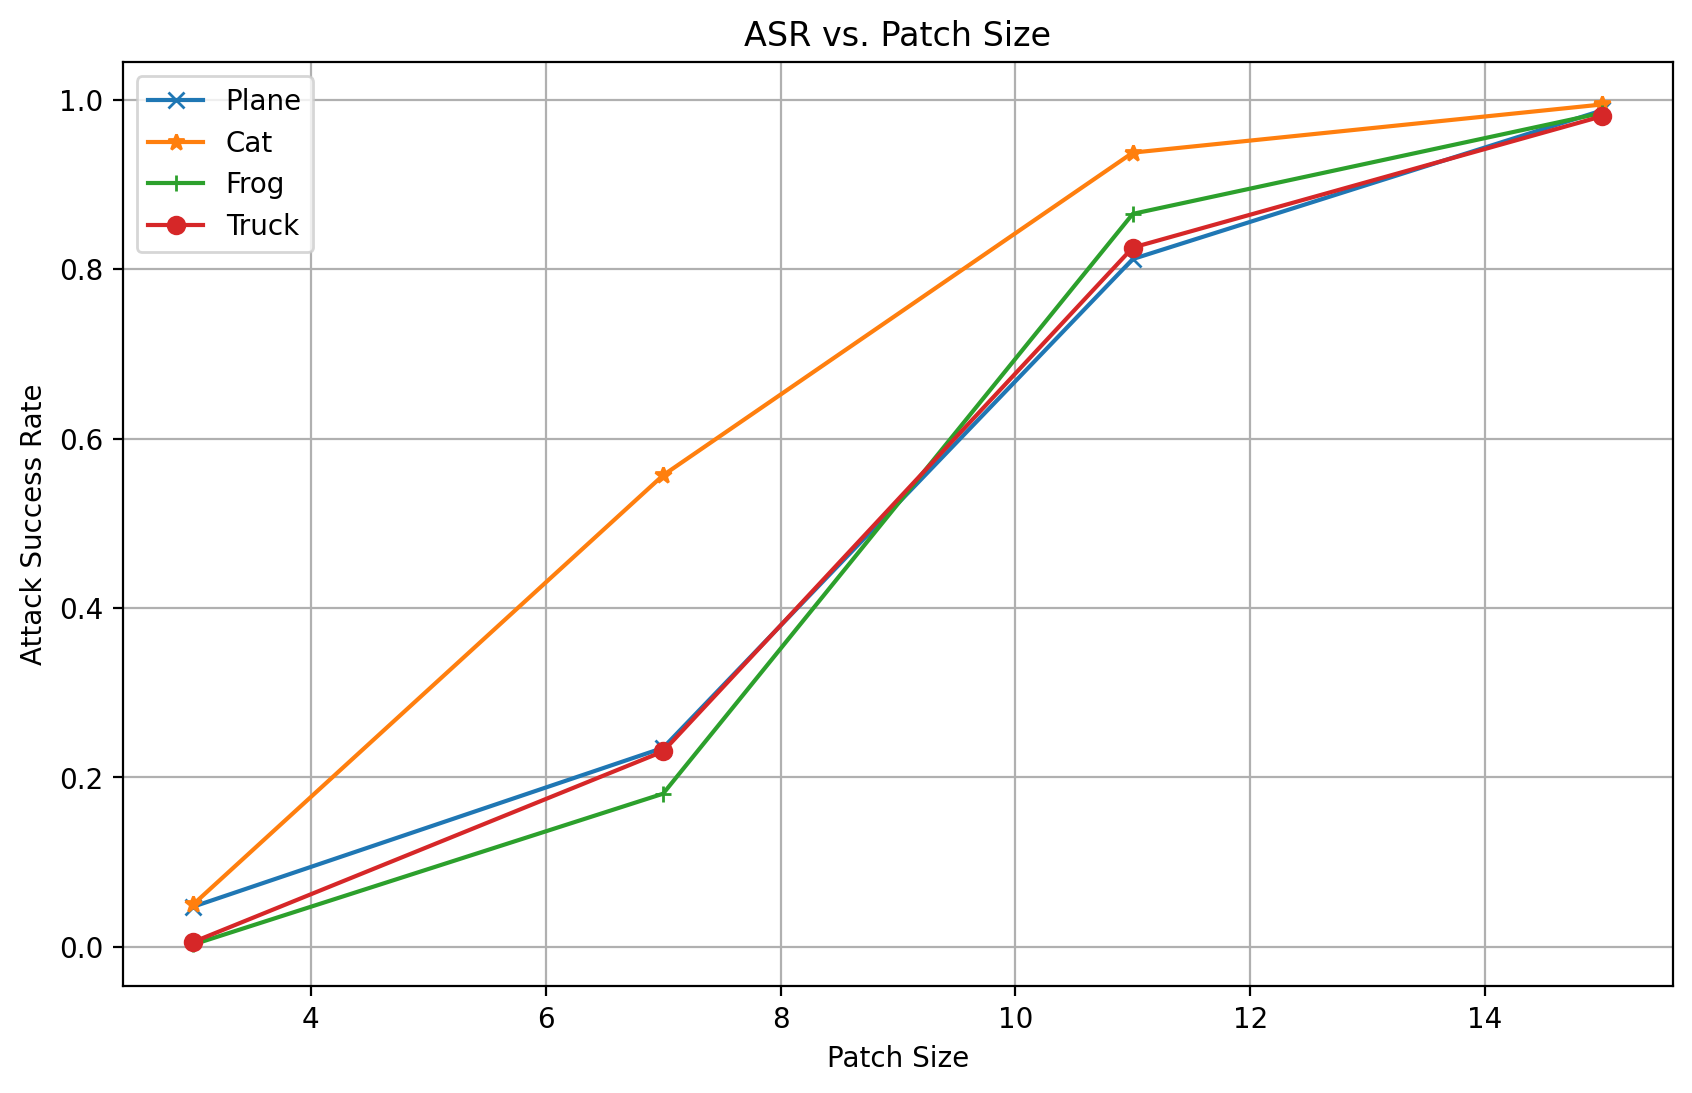

In [ ]:
def plot_results(results, plot_type):
    # Define the categories for the plots
    categories = {None: 'Untargeted', 0: 'Plane', 3: 'Cat', 6: 'Frog', 9: 'Truck'}
    markers = ['x', '*', '+', 'o', '^']
    marker_idx = 0

    plt.figure(figsize=(10, 6))
    for target in categories.keys():
        # Skip the untargeted category for ASR plot
        if plot_type == "asr" and target is None:
            continue

        x = []  # Patch sizes
        y = []  # Test Accuracy or ASR

        for size in results:
            x.append(size)
            if target in results[size]:
                if plot_type == "test_acc":
                    y.append(results[size][target][0])
                elif plot_type == "asr":
                    y.append(results[size][target][1])

        plt.plot(x, y, label=categories[target], marker=markers[marker_idx])
        marker_idx += 1

    # Setting labels, title, and grid
    plt.xlabel('Patch Size')
    plt.ylabel('Test Accuracy' if plot_type == "test_acc" else 'Attack Success Rate')
    plt.title('Model Test Accuracy vs. Patch Size' if plot_type == "test_acc" else 'ASR vs. Patch Size')
    plt.grid(True)
    plt.legend()
    plt.show()


# Plot test accuracy and ASR
plot_results(results, "test_acc")
plot_results(results, "asr")

In [ ]:
base_results = results

# Explore Transferability

In [22]:
resnet20_16_untargeted = train_patch(MODELS['resnet20'].to(device), train_loader, None, device, (16,16))

Epoch  0 , Accuracy:  0.0515
Epoch  1 , Accuracy:  0.0395
Epoch  2 , Accuracy:  0.038625


In [24]:
_, _ = test_patch(MODELS['resnet20'], test_loader, None, resnet20_16_untargeted, device)

Model test accuracy: 0.10
Attack Success Rate: 0.00


In [26]:
resnet56 = resnet56.to(device)
_, _ = test_patch(MODELS['resnet56'], test_loader, None, resnet20_16_untargeted, device)

Model test accuracy: 0.25
Attack Success Rate: 0.00


In [27]:
vgg16 = vgg16.to(device)
_, _ = test_patch(MODELS['vgg'], test_loader, None, resnet20_16_untargeted, device)

Model test accuracy: 0.24
Attack Success Rate: 0.00


In [28]:
mobilenet = mobilenet.to(device)
_, _ = test_patch(MODELS['mobilenet'], test_loader, None, resnet20_16_untargeted, device)

Model test accuracy: 0.29
Attack Success Rate: 0.00


In [29]:
shufflenet = shufflenet.to(device)
_, _ = test_patch(MODELS['shufflenet'], test_loader, None, resnet20_16_untargeted, device)

Model test accuracy: 0.41
Attack Success Rate: 0.00


In [30]:
repvgg = repvgg.to(device)
_, _ = test_patch(MODELS['repvgg'], test_loader, None, resnet20_16_untargeted, device)

Model test accuracy: 0.28
Attack Success Rate: 0.00


In [36]:
def train_and_test_transferability(models, train_loader, test_loader, device, target=None, patch_size=(3,3)):
    # Train patch on the first model (assumed to be ResNet20)
    trained_patch = train_patch(models['resnet20'].to(device), train_loader, target, device, patch_size)

    results = {}
    for model_name, model in models.items():
        model.to(device)
        test_acc, asr = test_patch(model, test_loader, target, trained_patch, device)
        results[model_name] = (test_acc, asr)
        print(f"Tested on {model_name}: Test Accuracy = {test_acc}, ASR = {asr}")

    return results

In [71]:
def plot_transferability_results(results, target):
    model_names = list(results.keys())
    test_accs = [results[model][0] for model in model_names]
    x = np.arange(len(model_names))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax1 = plt.subplots()

    if target is not None:
        # Plot both test accuracy and ASR with double y-axis
        asrs = [results[model][1] for model in model_names]

        # Test Accuracy
        rects1 = ax1.bar(x - width/2, test_accs, width, label='Test Accuracy', color='blue')
        ax1.set_ylabel('Test Accuracy', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.bar_label(rects1, padding=3, fmt='%.2f')

        # ASR
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        rects2 = ax2.bar(x + width/2, asrs, width, label='ASR', color='green')
        ax2.set_ylabel('ASR', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.bar_label(rects2, padding=3, fmt='%.2f')

        fig.tight_layout()  # to adjust the plot layout
    else:
        # Plot only test accuracy
        rects = ax1.bar(x, test_accs, width, label='Test Accuracy', color='blue')
        ax1.set_ylabel('Test Accuracy', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.bar_label(rects, padding=3, fmt='%.2f')

    # Common settings for both plots
    ax1.set_title('Transferability with 15x15 Targeted Patches' if target is not None else 'Transferability with 15x15 Untargeted Patches')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names)

    if target is not None:
      # Get the handles and labels for both axes
      handles1, labels1 = ax1.get_legend_handles_labels()
      handles2, labels2 = ax2.get_legend_handles_labels()

      # Combine handles and labels
      handles = handles1 + handles2
      labels = labels1 + labels2

      # Create a single legend
      plt.legend(handles, labels, loc='upper center')
    else: ax1.legend(loc='upper left')

    plt.show()


In [82]:
untargeted_transfer_results = train_and_test_transferability(MODELS, train_loader, test_loader, device, target=None, patch_size=(15,15))

Epoch  0 , Accuracy:  0.070425
Epoch  1 , Accuracy:  0.0426
Epoch  2 , Accuracy:  0.04065
Model test accuracy: 0.11
Attack Success Rate: 0.00
Tested on resnet20: Test Accuracy = 0.1083, ASR = 0.0
Model test accuracy: 0.30
Attack Success Rate: 0.00
Tested on resnet56: Test Accuracy = 0.3016, ASR = 0.0
Model test accuracy: 0.37
Attack Success Rate: 0.00
Tested on vgg: Test Accuracy = 0.3712, ASR = 0.0
Model test accuracy: 0.38
Attack Success Rate: 0.00
Tested on mobilenet: Test Accuracy = 0.3831, ASR = 0.0
Model test accuracy: 0.55
Attack Success Rate: 0.00
Tested on shufflenet: Test Accuracy = 0.5525, ASR = 0.0
Model test accuracy: 0.39
Attack Success Rate: 0.00
Tested on repvgg: Test Accuracy = 0.3856, ASR = 0.0


In [75]:
targeted_transfer_results = train_and_test_transferability(MODELS, train_loader, test_loader, device, target=0, patch_size=(15,15))

Epoch  0 , Accuracy:  0.0656
Epoch  1 , Accuracy:  0.046875
Epoch  2 , Accuracy:  0.0444
Model test accuracy: 0.02
Attack Success Rate: 0.98
Tested on resnet20: Test Accuracy = 0.01577777777777778, ASR = 0.984
Model test accuracy: 0.41
Attack Success Rate: 0.50
Tested on resnet56: Test Accuracy = 0.4057777777777778, ASR = 0.49777777777777776
Model test accuracy: 0.36
Attack Success Rate: 0.55
Tested on vgg: Test Accuracy = 0.35844444444444445, ASR = 0.5506666666666666
Model test accuracy: 0.37
Attack Success Rate: 0.54
Tested on mobilenet: Test Accuracy = 0.3701111111111111, ASR = 0.5442222222222223
Model test accuracy: 0.52
Attack Success Rate: 0.32
Tested on shufflenet: Test Accuracy = 0.5161111111111111, ASR = 0.3231111111111111
Model test accuracy: 0.41
Attack Success Rate: 0.50
Tested on repvgg: Test Accuracy = 0.41333333333333333, ASR = 0.5


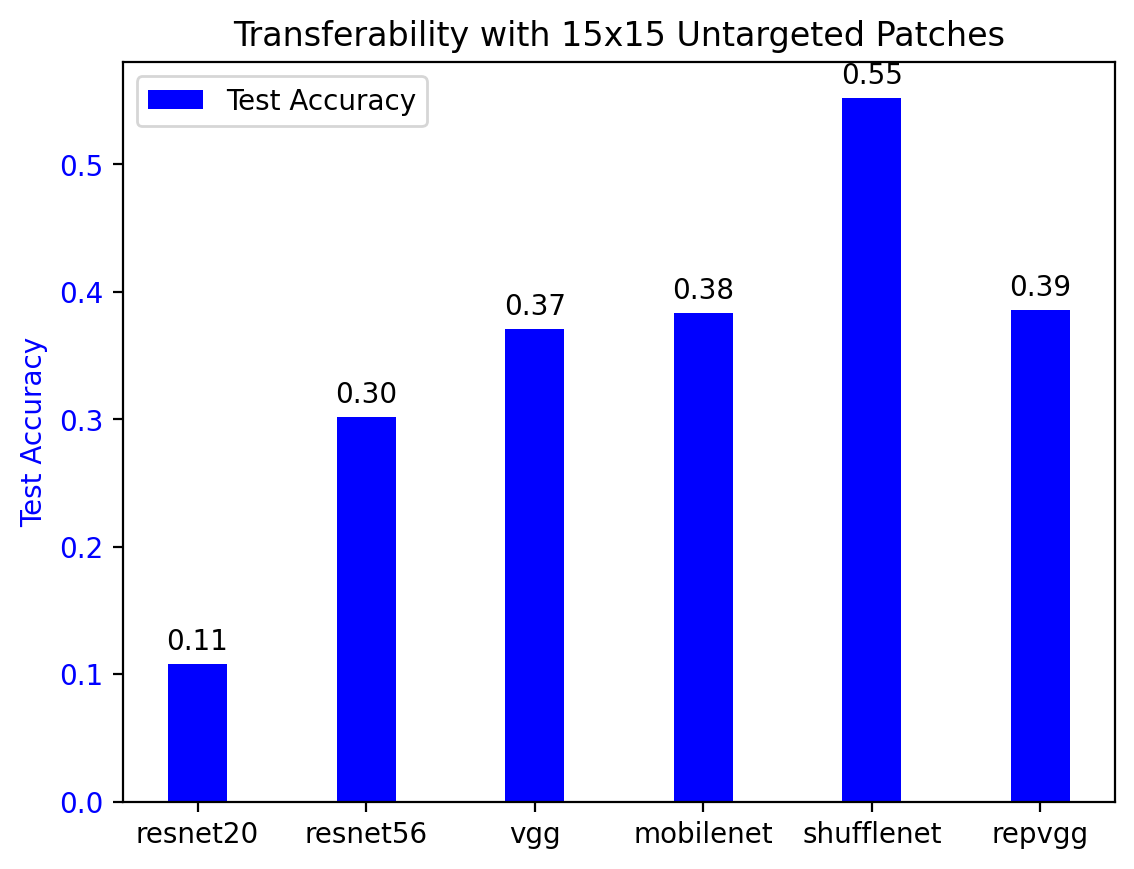

In [83]:
plot_transferability_results(untargeted_transfer_results, None)

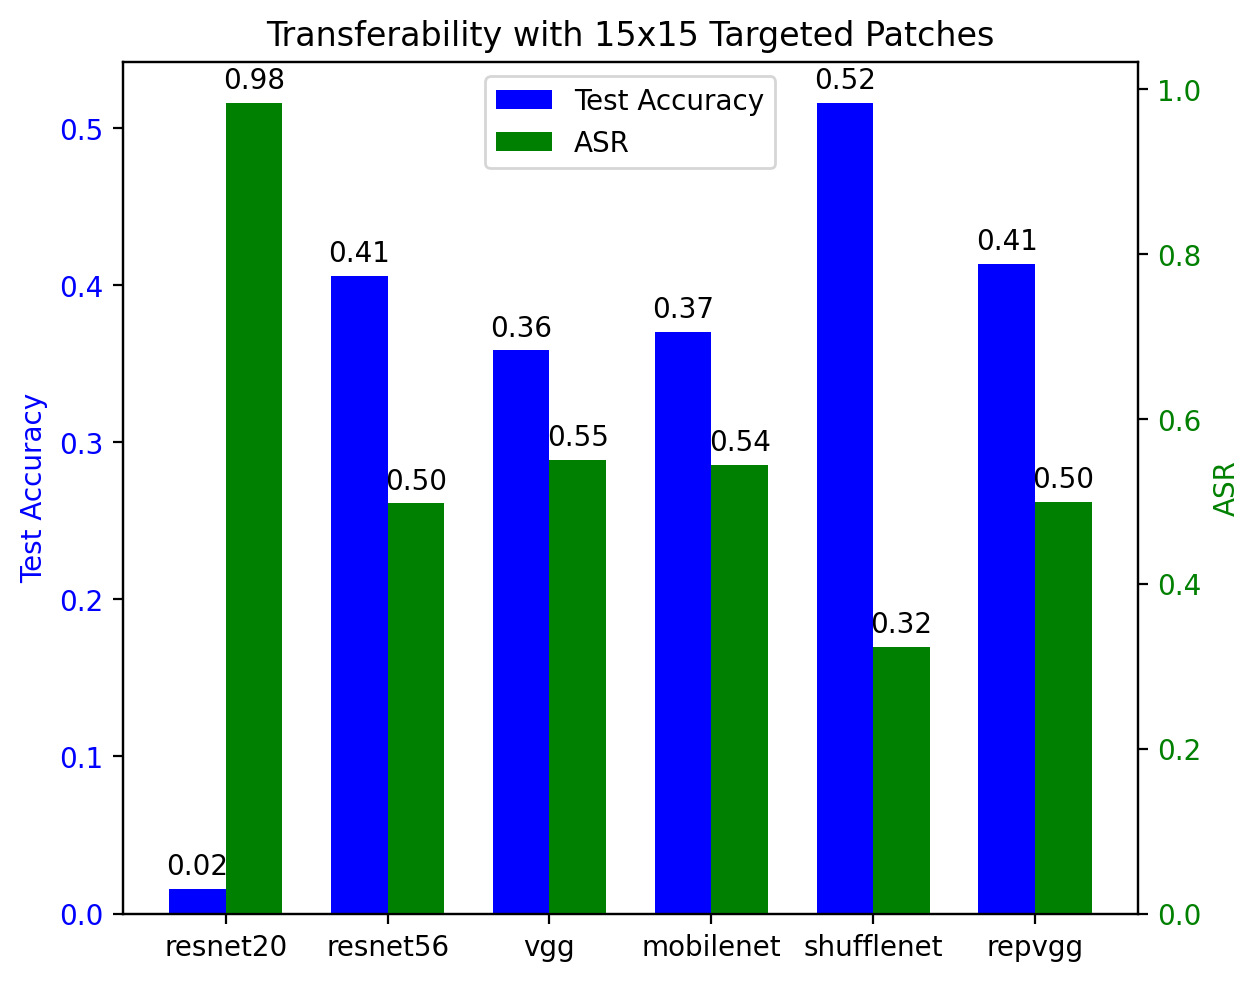

In [84]:
plot_transferability_results(targeted_transfer_results, 0)